# Generalized Cross-Validation Experiment
*This notebook runs an experiment to compare the performance of ridge regression when set using different cross-validation metrics.*

## Import dependencies

In [1]:
import numpy as np
import scipy
from collections import defaultdict
import peak_engines
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Set up simulation

In [2]:
p = 0.1
k = 5
beta = np.array([10, 0, 1, -0.01, 0.1])
sigma = 1.0

In [3]:
def generate_data(n):
    X = np.random.binomial(1, p, size=(n, k))
    y = np.dot(X, beta) + np.random.normal(0, sigma, size=n)
    return X, y

In [4]:
def validate_models(models, n, num_trials):
    result = defaultdict(list)
    for _ in range(num_trials):
        X, y = generate_data(n+2000)
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, train_size=n, shuffle=False)
        for name, model in models:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            result[name].append(mean_squared_error(y_test, y_pred))
    return result

def run_simulation(models, train_sizes, num_trials):
    result = defaultdict(lambda: defaultdict(list))
    for n in train_sizes:
        for name, errors in validate_models(models, n, num_trials).items():
            mean = np.mean(errors)
            stddev = np.std(errors, ddof=1)
            interval = scipy.stats.t.interval(alpha=0.95, df=num_trials-1, scale=stddev/np.sqrt(num_trials))
            result[name]['mean'].append(mean)
            result[name]['error_bar'].append(interval[1])
    return result

## Run simulation

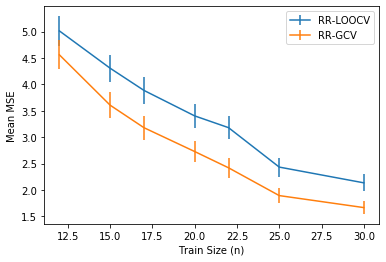

In [5]:
np.random.seed(0)
models = [
    ('RR-LOOCV', peak_engines.RidgeRegressionModel(score='loocv')),
        # Set ridge regression's regularizer so as to minimize the error of the 
        # leave-one-out cross-validation of the training data
    ('RR-GCV', peak_engines.RidgeRegressionModel(score='gcv')),
        # Set ridge regression's regularizer so as to minimize the error of the
        # generalized cross-validation of the training data
]
train_sizes = [12, 15, 17, 20, 22, 25, 30]
num_trials = 1000
simulation_results = run_simulation(models, train_sizes, num_trials)

for name, simulation_result in simulation_results.items():
    plt.errorbar(train_sizes, 
                 simulation_result['mean'], 
                 yerr=simulation_result['error_bar'], 
                 label=name)
plt.legend(loc='upper right')
plt.xlabel('Train Size (n)')
plt.ylabel('Mean MSE')
plt.show()